In [34]:
import os
import shutil
import math

import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['figure.facecolor'] = '#ffffff'



In [35]:
# from google.colab import drive
# drive.mount('/content/drive')

In [36]:
# import zipfile
# with zipfile.ZipFile('./Dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('./dataset')

In [37]:
# import zipfile
# with zipfile.ZipFile('./drive/MyDrive/HW2/Dataset.zip', 'r') as zip_ref:
#     zip_ref.extractall('./dataset')

In [38]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


In [39]:
# # # Organize data into training and test datasets

data_dir = './dataset'
test_files = []

# Remove all previous datasets
for x in range(5):
    shutil.rmtree(data_dir + "/train" + str(x))
    shutil.rmtree(data_dir + "/test" + str(x))

for x in range(10): # Loop 10 times for each class
    # split images into 8:2
    files = os.listdir(data_dir + "/" + str(x))
    train_files = files[:int(len(files)*0.8)]
    
    train_files_new = [None] * len(train_files)
    path = "./dataset/train" + str(int(x/2)) +  "/" + str(x)
    
    # Create directory if not created
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
        
    # copy to new path
    for y in range(len(train_files)):
        print(data_dir + "/" + str(x) + "/" + train_files[y])
        shutil.copyfile(data_dir + "/" + str(x) + "/" + train_files[y], path + "/" + train_files[y])
    
        
    # same but for test images
    test_files = files[int(len(files)*0.8):len(files)]
    test_files_new = [None] * int(len(test_files)/5)
    
    for y in range(5): # Loop for each dataset
        test_file_dataset = test_files[y*int(len(test_files)/5):(y+1)*int(len(test_files)/5)]
        path = "./dataset/test" + str(y) + "/" + str(x)
        
        # Create directory if not created
        isExist = os.path.exists(path)
        if not isExist:
            os.makedirs(path)
            
        for z in range(len(test_file_dataset)):
            print(data_dir + "/" + str(x) + "/" + test_files[y])
            shutil.copyfile(data_dir + "/" + str(x) + "/" + test_files[z], path + "/" + test_files[z])

FileNotFoundError: [Errno 2] No such file or directory: './dataset/train0'

##### Check if training dataset is correctly created

In [ ]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor

train_dataset = [None] * 5
test_dataset = [None] * 5
for x in range(5):
    print(x)
    train_dataset[x] = ImageFolder(data_dir+'/train'+str(x), transform=ToTensor())
    print(len(train_dataset[x]))
    print(train_dataset[x].classes)
    test_dataset[x] = ImageFolder(data_dir+'/test'+str(x), transform=ToTensor())
    print(len(test_dataset[x]))
    print(test_dataset[x].classes)

0


FileNotFoundError: [Errno 2] No such file or directory: './dataset/train0'

##### Create validation set 

In [ ]:
# # Set seed to always create the same validation set
# import torch

# torch.manual_seed(10)

# val_size_ratio = 0.1
# val_size = int(len(train_dataset[0]) * val_size_ratio)
# val_dataset = [None] * 5

# for x in range(5):
#     train_size = len(train_dataset[x]) - val_size

#     train_dataset[x], val_dataset[x] = random_split(train_dataset[x], [train_size, val_size])
#     print(len(train_dataset[x]), len(val_dataset[x]))

7200 800
7200 800
7200 800
7200 800
7200 800


##### Create dataloader object

In [26]:
from torch.utils.data.dataloader import DataLoader

batch_size=8

train_dataload = [None]*5
test_dataload = [None]*5
val_dataload = [None]*5
for x in range(5):
    print(x)
    train_dataload[x] = DataLoader(train_dataset[x], batch_size, shuffle=True, num_workers=2, pin_memory=True)
    data_iter = iter(train_dataload[x])
    images, labels = next(data_iter)
    print(labels)
    test_dataload[x] = DataLoader(test_dataset[x], batch_size, shuffle=True, num_workers=2, pin_memory=True)
    data_iter = iter(test_dataload[x])
    images, labels = next(data_iter)
    print(labels)
    # val_dataload[x] = DataLoader(val_dataset[x], batch_size, num_workers=2, pin_memory=True)

0
tensor([0, 1, 1, 0, 1, 0, 1, 1])
tensor([6, 7, 5, 1, 8, 9, 5, 5])
1
tensor([0, 0, 0, 1, 1, 0, 0, 1])
tensor([8, 4, 1, 1, 3, 0, 2, 2])
2
tensor([1, 1, 0, 0, 0, 1, 0, 0])
tensor([1, 1, 0, 7, 8, 3, 6, 9])
3
tensor([1, 0, 1, 1, 1, 1, 1, 1])
tensor([4, 9, 0, 0, 4, 7, 1, 5])
4
tensor([1, 0, 0, 0, 1, 0, 1, 0])
tensor([1, 3, 4, 8, 4, 0, 3, 6])


Dataset: 0
train


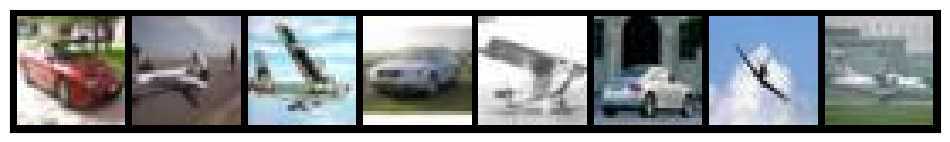

Class:      1     0     0     1     0     1     0     0
test


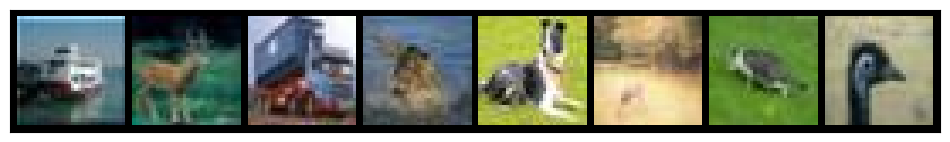

Class:      8     4     9     2     5     4     3     2
Dataset: 1
train


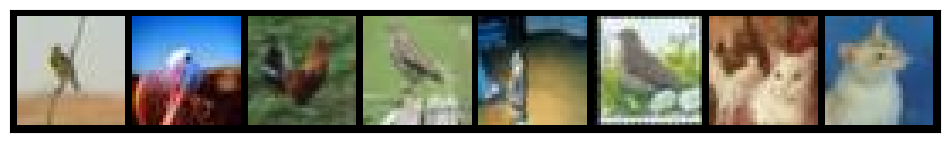

Class:      0     0     0     0     1     0     1     1
test


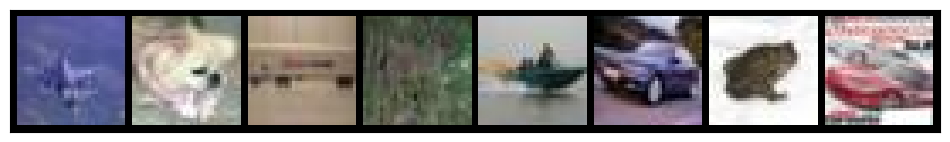

Class:      0     5     9     4     8     1     6     1
Dataset: 2
train


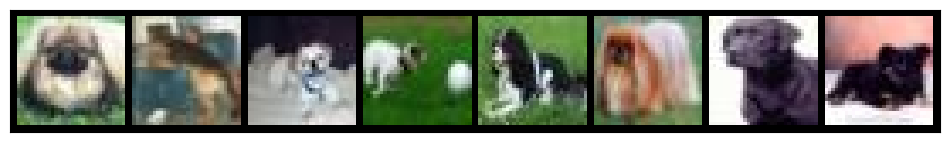

Class:      1     1     1     1     1     1     1     1
test


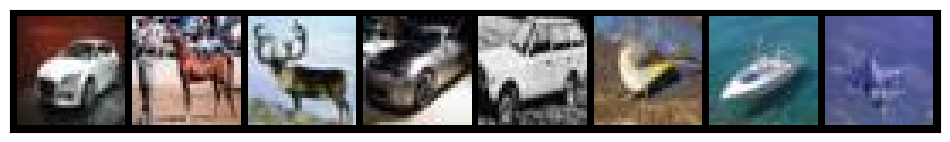

Class:      1     7     4     1     1     2     8     0
Dataset: 3
train


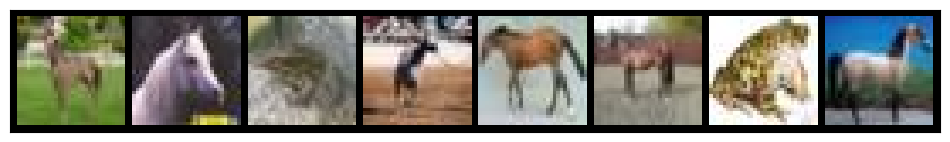

Class:      1     1     0     1     1     1     0     1
test


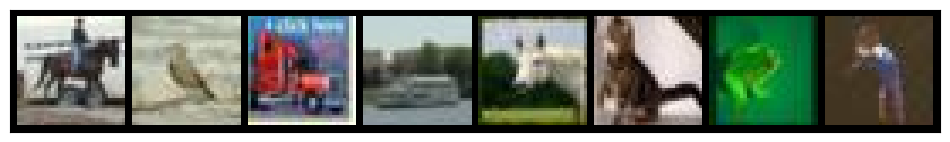

Class:      7     2     9     8     7     3     6     2
Dataset: 4
train


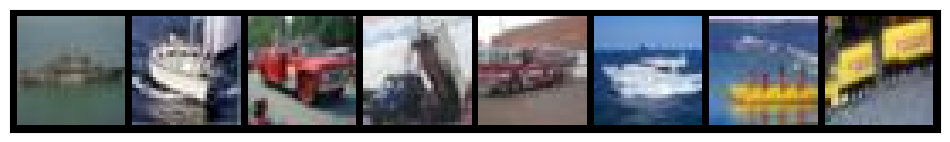

Class:      0     0     1     1     1     0     0     1
test


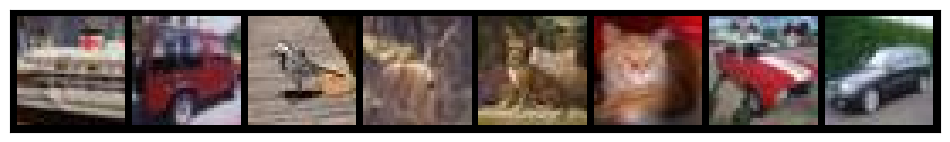

Class:      8     1     2     4     5     3     1     1


In [33]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        plt.show()
        print('Class: ', ' '.join(f'{labels[j]:5}' for j in range(batch_size)))
        break

for x in range(5):
    print("Dataset: " + str(x))
    print("train")
    show_batch(train_dataload[x])
    print("test")
    show_batch(test_dataload[x])
    # print("validation")
    # show_batch(val_dataload[x])

In [ ]:
# define CNN

import torch.nn as nn
import torch
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=False),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc1 = nn.Linear(32*16*16, 2048)
        self.fc2 = nn.Linear(2048, 512)
        self.fc3 = nn.Linear(512, 128)
        self.fc4 = nn.Linear(128, 32)
        self.fc5 = nn.Linear(32, 10)
            
    def forward(self, x):
        x = self.conv(x)

        x = x.view(-1, 32*16*16)
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.fc4(x)
        x = torch.relu(x)
        x = self.fc5(x)
        x = torch.log_softmax(x, dim=1)
        return x
    
cnn = CNN()
# Set device to GPU
cnn.to(device)

# Define loss function and optimizer

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(cnn.parameters(), lr=0.001, momentum=0.9)

##### Train network

In [ ]:
# Train network
!pip install avalanche-lib[all]

from avalanche.benchmarks.classic import PermutedMNIST


def train(dataset_no):
    running_loss = 0.0
    for epoch in range(2):  # loop over the dataset multiple times
        for i, data in enumerate(train_dataload[dataset_no], 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)


            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = cnn(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 100 == 0:    # print every batch size
                print(f'[{dataset_no}, {epoch}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0

    # Save model
    PATH = './CNN_model'
    torch.save(cnn.state_dict(), PATH)
    
    print('Finished Training dataset: ' + str(dataset_no))

In [235]:
def test(dataset_no): 
  # Test images

  correct = 0
  total = 0
  # since we're not training, we don't need to calculate the gradients for our outputs
  with torch.no_grad():
      for data in test_dataload[dataset_no]:
          inputs, labels = data
          inputs, labels = inputs.to(device), labels.to(device)
          # calculate outputs by running images through the network
          outputs = cnn(inputs)
          # the class with the highest energy is what we choose as prediction
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print(f'Accuracy of the network on the test images: {100 * correct // total} %')

In [242]:
# Test some images
def test_show(dataset_no):
    dataiter = iter(train_dataload[dataset_no])
    inputs, labels = next(dataiter)

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(inputs, nrow=16).permute(1, 2, 0))
    plt.show()

    print('GroundTruth: ', ' '.join(f'{labels[j]:5}' for j in range(batch_size)))

    
    inputs, labels = inputs.to(device), labels.to(device)
    outputs = cnn(inputs)
    _, predicted = torch.max(outputs, 1)

    print('Predicted: ', ' '.join(f'{predicted[j]:5}'for j in range(batch_size)))
    

Dataset: 0


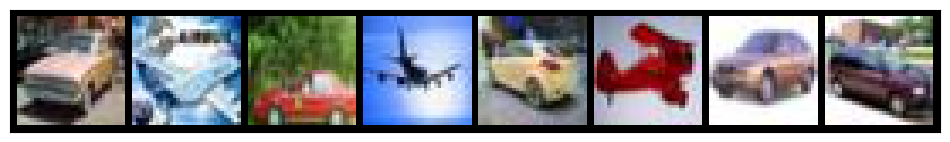

GroundTruth:      1     0     1     0     1     0     1     1
Predicted:      1     1     0     0     1     1     1     1
Dataset: 1


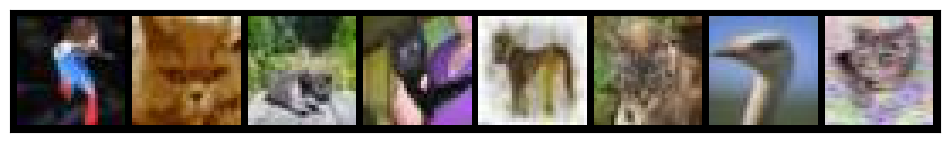

GroundTruth:      0     1     1     1     1     1     0     1
Predicted:      0     1     1     0     1     0     0     1
Dataset: 2


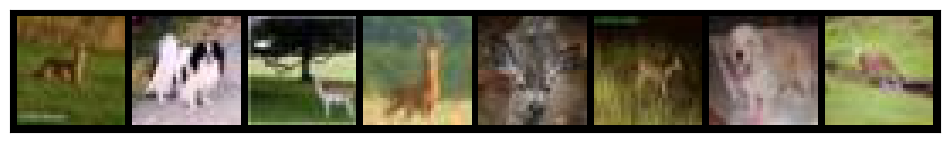

GroundTruth:      0     1     0     0     0     0     1     0
Predicted:      0     1     1     0     1     1     1     0
Dataset: 3


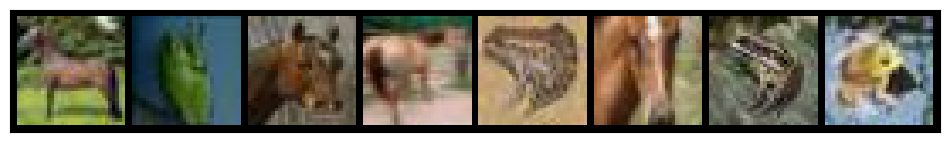

GroundTruth:      1     0     1     1     0     1     0     0
Predicted:      1     0     1     1     1     1     1     1
Dataset: 4


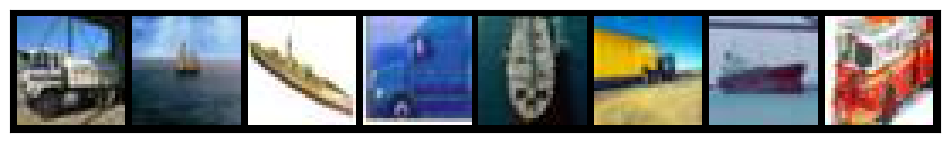

GroundTruth:      1     0     0     1     0     1     0     1
Predicted:      1     0     0     0     1     0     1     1


In [243]:
for x in range(5):
  print("Dataset: " + str(x))
  
  test_show(x)

dataset 0


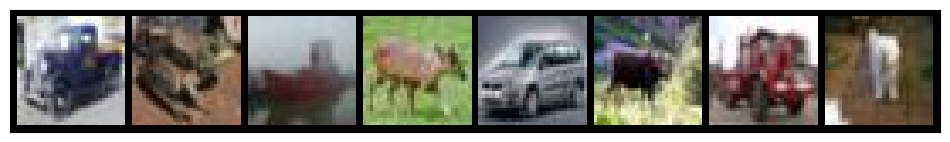

GroundTruth:      9     6     8     4     1     4     9     5
Predicted:      1     1     1     0     1     1     1     1
dataset 1


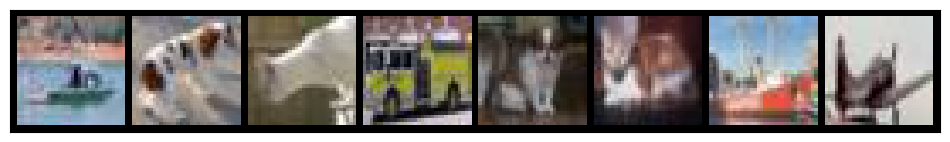

GroundTruth:      8     5     3     9     5     3     8     0
Predicted:      1     1     0     1     1     1     1     1


In [240]:
for x in range(5):
    train(x)
    test(x)
    test_show(x)

Test if model is working